# Camera Lidar Temporal Calibration On the fly

# Problem 

**1. Temporal drift destroys geometric alignment**

- Even a 5–20 ms offset is enough to misalign edges, walls, and object contours between sensors.
- In fast motion, the LiDAR sees one world, the camera sees another.

**2. Offline calibration becomes invalid during real robot operation**

- You can calibrate once in the lab, and your timestamps will still drift in the field because of:
- temperature changes
- CPU/GPU load
- network delays
- sensor driver jitter

So the calibration you trusted is probably lying to you after 10–20 minutes of operation.

**3. On-the-fly calibration removes the need for special setups or checkerboards**

- Most robotic systems can’t afford stopping to recalibrate sensors every time hardware jitters.
- A runtime module that continuously estimates the offset keeps the system robust without user intervention.

In [1]:
# !pip install --upgrade "numpy>=2.0"
# !pip install --upgrade scipy
# !pip install --upgrade numpy scipy opencv-python
#!pip install --upgrade matplotlib

In [2]:
import os
import joblib
import pickle
from scipy.optimize import minimize
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from typing import List, Dict

from extract_topics import McapTimeWindowExtractor
from imu_utils import IMUPreintegrator

# Code For The Imu-Preintegration Pipeline

In [3]:
class IMUPreintegrator:
    def __init__(self,
                 gravity: np.ndarray = np.array([0, 0, 9.81]),
                 verbose: bool = False):
        """
        Calculates relative motion (Dead Reckoning) from IMU data.
        
        :param gravity: Gravity vector in the IMU frame. 
                        Usually [0, 0, 9.81] if Z is UP.
                        Change to [0, 0, -9.81] if Z is DOWN.
        """
        self.gravity = gravity
        self.verbose = verbose
        self.reset()
        
    def reset(self):
        self.delta_R = Rotation.identity()
        self.delta_v = np.zeros(3)
        self.delta_p = np.zeros(3)
        self.delta_t = 0.0
        
    def preintegrate(self, 
                     imu_measurements: List[Dict],
                     t_start: float,
                     t_end: float) -> np.ndarray:
        """
        Integrates IMU messages between t_start and t_end.
        Returns: 4x4 Transformation Matrix (T_v) representing motion.
        """
        
        # 1. Filter IMU data to strict time window
        # We assume the list is sorted by time
        relevant_imu = [
            m for m in imu_measurements 
            if m['timestamp_sec'] >= t_start and m['timestamp_sec'] <= t_end
        ]

        if len(relevant_imu) < 2:
            if self.verbose: 
                print(f"Warning: Not enough IMU data between {t_start:.3f} and {t_end:.3f}")
            return np.eye(4) # Return Identity (No motion)
        
        self.delta_t = t_end - t_start
        self.reset()
        
        # 2. Integration Loop
        prev_time = relevant_imu[0]['timestamp_sec']
        
        for i in range(1, len(relevant_imu)):
            imu = relevant_imu[i]
            t_curr = imu['timestamp_sec']
            dt = t_curr - prev_time
            
            if dt <= 0: continue
            
            # Extract data (Expecting numpy arrays from extract_topics.py)
            acc = imu['linear_acceleration']
            gyro = imu['angular_velocity']
            
            self._integrate_step(acc, gyro, dt)
            prev_time = t_curr
            
        return self.get_transform_matrix()
    
    def _integrate_step(self, acc: np.ndarray, gyro: np.ndarray, dt: float):
        """ Standard Strapdown Inertial Navigation integration (Euler) """
        
        # 1. Update Rotation (Gyro)
        # Calculate angle change
        delta_angle = gyro * dt
        delta_rotation = Rotation.from_rotvec(delta_angle)
        
        # 2. Update Position & Velocity (Accel)
        # Rotate acceleration from Body Frame to World Frame
        acc_world = self.delta_R.apply(acc)
        
        # Subtract Gravity (Crucial!)
        acc_net = acc_world - self.gravity
        
        # Euler Integration: p = p + v*dt + 0.5*a*dt^2
        self.delta_p += self.delta_v * dt + 0.5 * acc_net * dt**2
        self.delta_v += acc_net * dt
        
        # Update Accumulator
        self.delta_R = self.delta_R * delta_rotation
    
    def get_transform_matrix(self) -> np.ndarray:
        T = np.eye(4)
        T[:3, :3] = self.delta_R.as_matrix()
        T[:3, 3] = self.delta_p
        return T

# Visuals For Imu-Preintegration

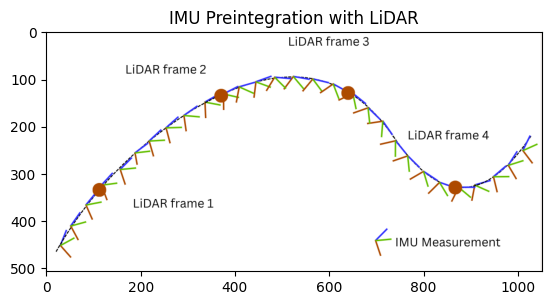

In [4]:
img = cv2.imread("images/imu_preintegration.png")
plt.imshow(img)
plt.title("IMU Preintegration with LiDAR")
plt.show()

# Code For The Lidar Pipeline

In [5]:
# ================================
# CONFIGURATION
# ================================
MCAP_PATH       = "huntington.mcap"
CAMERA_TOPIC    = "/cam_sync/cam0/image_raw/compressed"
LIDAR_TOPIC     = "/ouster/points"
IMU_TOPIC       = "/vectornav/imu_uncompensated"

# Use the SAME window as you used for camera extraction
START_TIME = 10.0   # seconds from bag start
DURATION   = 5.0    # seconds

# Where to save the final densified LiDAR frames
OUTPUT_DIR      = "/home/aryaman/Huntington_Data/calib_cache"
OUTPUT_FILENAME = os.path.join(OUTPUT_DIR, "lidar_scans.pkl")

# LiDAR projection params (as before)
H, W = 128, 1024
FOV_UP, FOV_DOWN = 22.5, -22.5


# ================================
# LiDAR helper functions
# ================================
def project_to_range_image(points, height=128, width=1024):
    """Project 3D points to a (height, width, 3) grid in LiDAR coordinates."""
    total = height * width
    if points.shape[0] == total:
        return points.reshape(height, width, 3)

    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    r = np.linalg.norm(points, axis=1)
    valid_mask = r > 0.001

    u = np.zeros_like(x, dtype=int)
    v = np.zeros_like(x, dtype=int)

    if np.any(valid_mask):
        x_v, y_v, z_v, r_v = x[valid_mask], y[valid_mask], z[valid_mask], r[valid_mask]
        yaw = np.arctan2(y_v, x_v)
        pitch = np.arcsin(np.clip(z_v / r_v, -1, 1))

        u_val = 0.5 * (yaw / np.pi + 1.0) * width
        fov_range = np.deg2rad(FOV_UP - FOV_DOWN)
        v_val = (1.0 - (pitch - np.deg2rad(FOV_DOWN)) / fov_range) * height

        u[valid_mask] = u_val.astype(int)
        v[valid_mask] = v_val.astype(int)

    u = np.clip(u, 0, width - 1)
    v = np.clip(v, 0, height - 1)

    img = np.zeros((height, width, 3), dtype=np.float32)
    valid = valid_mask & (v >= 0) & (v < height) & (u >= 0) & (u < width)
    img[v[valid], u[valid]] = points[valid]

    return img


def extract_edges(grid_points):
    """Return edge points where range jumps > 1.0 m between horizontal neighbours."""
    ranges = np.linalg.norm(grid_points, axis=2)
    diff = np.abs(np.diff(ranges, axis=1))
    diff = np.pad(diff, ((0, 0), (0, 1)), constant_values=0)
    return grid_points[diff > 1.0]


def apply_transform(points, T):
    """Apply 4x4 transform T to Nx3 points."""
    if len(points) == 0:
        return points
    ones = np.ones((len(points), 1), dtype=points.dtype)
    pts_hom = np.hstack((points, ones))  # (N,4)
    pts_out = (T @ pts_hom.T).T
    return pts_out[:, :3]


# ================================
# MAIN
# ================================
def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print(f"Loading MCAP: {MCAP_PATH}")
    print(f"Time window: start={START_TIME}s  duration={DURATION}s")

    extractor = McapTimeWindowExtractor(
        mcap_path=MCAP_PATH,
        camera_topic=CAMERA_TOPIC,
        lidar_topic=LIDAR_TOPIC,
        imu_topic=IMU_TOPIC,
        start_time=START_TIME,
        duration=DURATION,
    )
    extractor.extract()

    print(f"\n[SUMMARY]")
    print(f"  Camera frames: {len(extractor.camera_frames)}")
    print(f"  LiDAR scans:   {len(extractor.lidar_scans)}")
    print(f"  IMU samples:   {len(extractor.imu_measurements)}")

    if len(extractor.imu_measurements) == 0:
        print("CRITICAL: No IMU data found, cannot motion-compensate LiDAR.")
        return

    # IMU preintegrator (sign of gravity should match imu_utils implementation)
    print("\nInitializing IMU preintegrator...")
    imu_integrator = IMUPreintegrator(gravity=np.array([0.0, 0.0, 9.81]))

    window = []         # stores last 3 frames: [{'t': ..., 'edges': ...}, ...]
    processed_data = [] # list of {'timestamp': float, 'points': (N,3) float32}

    total_scans = len(extractor.lidar_scans)
    print(f"\nProcessing {total_scans} LiDAR scans in calibration window...")

    t0 = time.time()

    for i, scan in enumerate(extractor.lidar_scans):
        if i % 10 == 0:
            print(f"  LiDAR scan {i}/{total_scans}")

        raw_points = scan["points"]          # (N,3)
        timestamp = scan["timestamp_sec"]    # float

        # 1. Feature extraction: range image + edge points
        grid = project_to_range_image(raw_points, H, W)
        edges = extract_edges(grid)
        if edges.size == 0:
            continue

        # 2. Push into sliding window
        window.append({"t": timestamp, "edges": edges})
        if len(window) > 3:
            window.pop(0)

        # 3. Once we have 3 frames, densify in the current frame coordinates
        if len(window) == 3:
            f_prev, f_curr, f_next = window[0], window[1], window[2]

            # IMU-based motion compensation:
            #  - bring prev -> curr
            T_p2c = imu_integrator.preintegrate(
                extractor.imu_measurements,
                f_prev["t"],
                f_curr["t"],
            )
            edges_prev_aligned = apply_transform(f_prev["edges"], T_p2c)

            #  - bring next -> curr
            T_c2n = imu_integrator.preintegrate(
                extractor.imu_measurements,
                f_curr["t"],
                f_next["t"],
            )
            T_n2c = np.linalg.inv(T_c2n)
            edges_next_aligned = apply_transform(f_next["edges"], T_n2c)

            # 4. Stack: densified, motion-corrected edges at f_curr time
            dense_corrected = np.vstack(
                [edges_prev_aligned, f_curr["edges"], edges_next_aligned]
            )

            frame_data = {
                "timestamp": float(f_curr["t"]),                 # keep key name 'timestamp'
                "points": dense_corrected.astype(np.float32),    # (N,3)
            }
            processed_data.append(frame_data)

    elapsed = time.time() - t0
    print(f"\nProcessing complete in {elapsed:.2f} s.")
    print(f"Generated {len(processed_data)} densified LiDAR frames.")

    print(f"\nSaving to {OUTPUT_FILENAME} ...")
    with open(OUTPUT_FILENAME, "wb") as f:
        pickle.dump(processed_data, f)

    print("Done.")


if __name__ == "__main__":
    main()


Loading MCAP: huntington.mcap
Time window: start=10.0s  duration=5.0s
Reading MCAP: huntington.mcap
Camera topic: /cam_sync/cam0/image_raw/compressed
LiDAR topic:  /ouster/points
IMU topic:    /vectornav/imu_uncompensated

Extracting time window:
  Start: +10.0s from bag start
  Duration: 5.0s


Extracting: 1149msg [00:08, 142.20msg/s]



  Extraction complete:
  Camera frames: 99
  LiDAR scans:   50
  IMU samples:   1000
  Actual time span: 4.90s

[SUMMARY]
  Camera frames: 99
  LiDAR scans:   50
  IMU samples:   1000

Initializing IMU preintegrator...

Processing 50 LiDAR scans in calibration window...
  LiDAR scan 0/50
  LiDAR scan 10/50
  LiDAR scan 20/50
  LiDAR scan 30/50
  LiDAR scan 40/50

Processing complete in 2.01 s.
Generated 48 densified LiDAR frames.

Saving to /home/aryaman/Huntington_Data/calib_cache/lidar_scans.pkl ...
Done.


# Lidar Edge Detection Video

In [5]:
from IPython.display import Video

# Use the converted file
Video("output.webm", width=600, height=400, embed=False)

# Code For The Camera Pipeline


**Algorithm: Camera edge & distance-transform pipeline**

Input:
  - Image path `path`
  - Canny thresholds `canny_low`, `canny_high`
  - Frame id `frame_id`

Output:
  - Stored grayscale image `images[frame_id]`
  - Stored edge map `edge_maps[frame_id]`
  - Stored normalized distance transform `dist_transforms[frame_id]`

Steps:
1. Load image</br>
   1.1. Read RGB image `img = cv2.imread(path)`. </br>
   1.2. Convert to grayscale:</br>
       - `gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)`.</br>
 
   1.3. Store:</br>
       - `images[frame_id] = gray`.</br>

2. Compute Canny edges</br>
   2.1. Run Canny:</br>
       - `edges = cv2.Canny(gray, canny_low, canny_high)`.</br>

   
   2.2. Binarize edges to 0 or 255:</br>
       - `edges = (edges > 0).astype(np.uint8) * 255`.</br>
   
   2.3. Store:</br>
       - `edge_maps[frame_id] = edges`.</br>

3. Compute distance transform</br>
   3.1. Invert edge image so edges become 0:</br>
       - `edges_inverted = 255 - edges`.</br>

   
   3.2. Compute distance to nearest edge pixel:</br>
       - `dist = cv2.distanceTransform(edges_inverted, DIST_L2, maskSize=5)`.</br>
       - 'Each pixel stores distance to the closest edge (0 for edge pixels).</br>
   
   3.3. Normalize to [0, 1] for numerical stability:</br>
       - If `dist.max() > 0`:</br>
           - `dist_norm = dist / dist.max()`</br>
         Else:</br>
           - `dist_norm = dist`.</br>

   3.4. Store:</br>
       - `dist_transforms[frame_id] = dist_norm`.</br>

4. Scoring projected LiDAR points (used later by optimizer)</br>
   4.1. Given projected pixel coordinates `projected_pixels`:</br>
       - Round to nearest integer pixel indices.</br>
       - Discard points that fall outside the image boundary.</br>

   4.2. For each remaining point (u, v), read its distance:</br>
       - `d = dist_norm[v, u]`.</br>
   
   4.3. Convert distances to edge-alignment scores:</br>
       - `score_i = exp(-d^2 / (2 * sigma^2))`.</br>

   4.4. Total score = sum of all `score_i`:</br>
       - Higher total score indicates LiDAR projection aligns better with image edges.


In [6]:
class CameraPipeline:
    def __init__(self, canny_low=50, canny_high=150):
        self.canny_low = canny_low
        self.canny_high = canny_high

        # Storage for images and derived maps
        self.images = {}            # frame_id -> grayscale image
        self.edge_maps = {}         # frame_id -> binary edges
        self.dist_transforms = {}   # frame_id -> float32 distance map

   
    # Step 1: Load & preprocess image
    def load_image(self, frame_id: int, path: str):
        # Load an image from disk, convert to grayscale, store by frame_id.
        
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {path}")

        # For now: no undistortion (no K/distortion yet)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        self.images[frame_id] = gray
        return gray

    # Step 2: Edge detection (Canny edges)
    def compute_edges(self, frame_id: int):
        # Compute Canny edges for the stored grayscale image.
        
        if frame_id not in self.images:
            raise KeyError(f"No image for frame_id={frame_id}")

        gray = self.images[frame_id]

        edges = cv2.Canny(gray, self.canny_low, self.canny_high)
        
        # Make edges strictly either 0 or 255
        edges = (edges > 0).astype(np.uint8) * 255

        self.edge_maps[frame_id] = edges
        return edges


    # Step 3: Distance transform from edge map
    def compute_distance_transform(self, frame_id: int):
      # Compute distance transform from the edge map. Pixels on edges have distances close to 0. 
      # Pixels far from edges tend to have large distances.

        if frame_id not in self.edge_maps:
            raise KeyError(f"No edge map for frame_id={frame_id}")

        edges = self.edge_maps[frame_id]

        # distanceTransform calculates distance of every pixel in the image and the corresponding nearest 0 pixel.
        # Currently, we have edges = 255 on edge, 0 elsewhere.
        dist = cv2.distanceTransform(
            255 - edges,  # Since we need distance of every pixel to nearest edge, we invert so edges become 0, background 255
            distanceType=cv2.DIST_L2,
            maskSize=5
        )

        # Normalize (0 <= distance <=1 )
        if dist.max() > 0:
            dist_norm = dist / dist.max()
        else:
            dist_norm = dist

        self.dist_transforms[frame_id] = dist_norm.astype(np.float32)
        return dist_norm

        
    # Step 4: Scoring API used later by the optimizer
    def score_projection(self, frame_id: int, projected_pixels: np.ndarray, sigma: float = 2.0) -> float:
       # Score a set of projected 2D points for alignment with image edges. Higher the score, better the alignment.

        if frame_id not in self.dist_transforms:
            raise KeyError(f"No distance transform for frame_id={frame_id}")

        dist = self.dist_transforms[frame_id]
        h, w = dist.shape

        if len(projected_pixels) == 0:
            return 0.0

        # Round to nearest pixel indices
        pts = projected_pixels.astype(np.int32)

        # Keep only those lidar points that are inside image bounds
        mask = (
            (pts[:, 0] >= 0) & (pts[:, 0] < w) &
            (pts[:, 1] >= 0) & (pts[:, 1] < h)
        )
        pts = pts[mask]
        if pts.shape[0] == 0:
            return 0.0

        # Gather distances from dist map
        d_vals = dist[pts[:, 1], pts[:, 0]]  # note: [row, col] => [v, u]

        # Convert distances to scores (smaller distance -> larger score)
        # score = exp(-d^2 / (2*sigma^2))
        scores = np.exp(-(d_vals ** 2) / (2.0 * sigma ** 2))

        return float(scores.sum())

   
    # Utility: visualize edges & distances
    def debug_show(self, frame_id: int, max_width: int = 1280, max_height: int = 720):
      # Show original image, edges, and distance transform side-by-side. The result is downscaled to fit within (max_width, max_height).
      
        if frame_id not in self.images:
            raise KeyError(f"No image for frame_id={frame_id}")
        if frame_id not in self.edge_maps:
            raise KeyError(f"No edge map for frame_id={frame_id}")
        if frame_id not in self.dist_transforms:
            raise KeyError(f"No dist transform for frame_id={frame_id}")

        img = self.images[frame_id]
        edges = self.edge_maps[frame_id]
        dist = self.dist_transforms[frame_id]

        # Normalize distance for display
        dist_disp = (dist * 255).astype(np.uint8)

        # Make them color for stacking
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        dist_color = cv2.applyColorMap(dist_disp, cv2.COLORMAP_JET)

        vis = np.hstack([img_color, edges_color, dist_color])

        # Resize to fit on screen
        h, w = vis.shape[:2]
        scale = min(max_width / w, max_height / h, 1.0)  # only shrink
        if scale < 1.0:
            vis = cv2.resize(vis, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)

        cv2.namedWindow(f"frame {frame_id}: [image | edges | dist]", cv2.WINDOW_NORMAL)
        cv2.imshow(f"frame {frame_id}: [image | edges | dist]", vis)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


    
    # Overlay projected points/lines
    def debug_overlay(self, frame_id: int, projected_pixels: np.ndarray,
                      show_edges: bool = False,
                      max_width: int = 1280, max_height: int = 720):
        # Draw projected LiDAR points on top of the image (or edge map).

        if frame_id not in self.images:
            raise KeyError(f"No image for frame_id={frame_id}")

        base = self.edge_maps[frame_id] if (show_edges and frame_id in self.edge_maps) else self.images[frame_id]
        h, w = base.shape

        # Make a color image for drawing
        overlay = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)

        if projected_pixels is not None and len(projected_pixels) > 0:
            pts = projected_pixels.astype(np.int32)

            # keep only in-bounds points
            mask = (
                (pts[:, 0] >= 0) & (pts[:, 0] < w) &
                (pts[:, 1] >= 0) & (pts[:, 1] < h)
            )
            pts = pts[mask]

            # draw small circles
            for (u, v) in pts:
                cv2.circle(overlay, (int(u), int(v)), 2, (0, 255, 0), -1)

        # Resize for display
        oh, ow = overlay.shape[:2]
        scale = min(max_width / ow, max_height / oh, 1.0)
        if scale < 1.0:
            overlay = cv2.resize(overlay, (int(ow * scale), int(oh * scale)), interpolation=cv2.INTER_AREA)

        cv2.namedWindow(f"frame {frame_id}: overlay", cv2.WINDOW_NORMAL)
        cv2.imshow(f"frame {frame_id}: overlay", overlay)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# Camera Pipeline Results


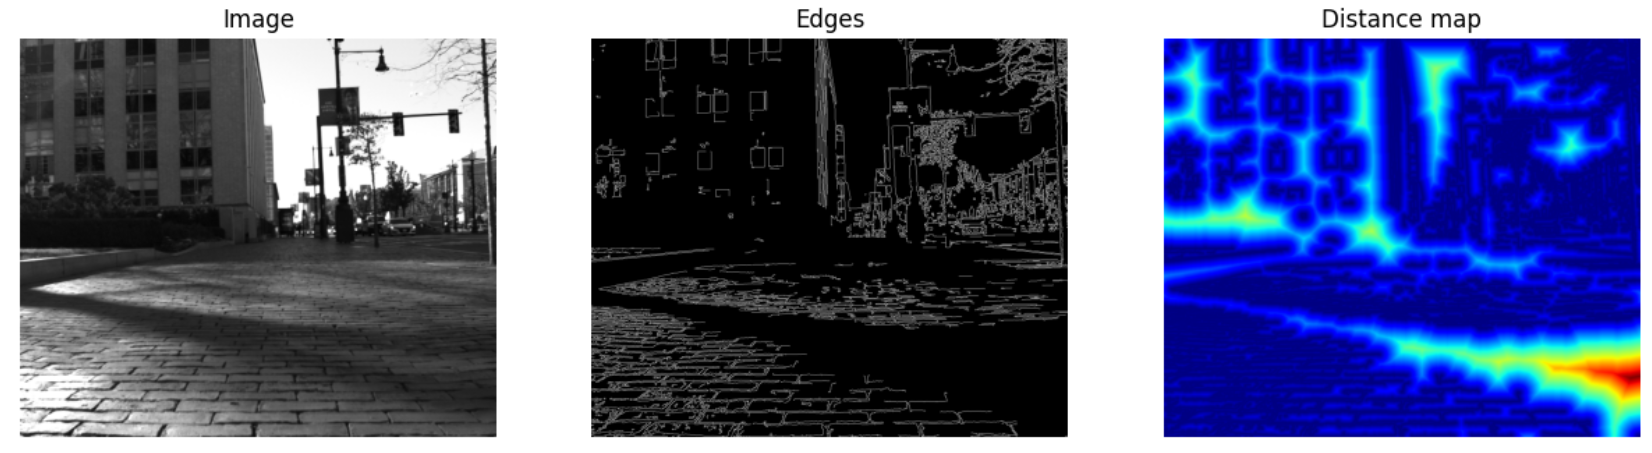

# Code For The Joint-Optimization Pipeline


**Algorithm: Joint optimization of time offset and extrinsics**

Given:
  - Precomputed camera data:
    - `pipeline` with:
        - `images[frame_id]`
        - `edge_maps[frame_id]`
        - `dist_transforms[frame_id]`
    - `cam_times`  (array of camera timestamps [sec])
    - `frame_ids`  (array of frame_ids aligned with cam_times)
    - Camera intrinsics `K` (3×3)
  - LiDAR scans (list of dicts):
    - For each scan `s`:
        - `s["timestamp_sec"]`  (LiDAR time [sec])
        - `s["points"]`         (N×3 array of LiDAR-frame points)
  - Initial LiDAR→camera transform `T_CL_init` (4×4)

We want to find:
  - `params = [tau, rx, ry, rz, tx, ty, tz]`
  - that minimize:  `objective(params) = - mean_edge_score`.

---

**Step 1: Define helper transforms**

1.1. Convert small Euler angles to rotation matrix:
  - `R_delta = euler_to_R(rx, ry, rz)`.

1.2. Build correction transform:
  - `T_delta = make_T(R_delta, [tx, ty, tz])`.

1.3. Updated LiDAR→camera transform:
  - `T_CL = T_CL_init @ T_delta`.

1.4. Transform LiDAR points to camera frame:
  - For each point `p_L`:
      - `p_C = T_CL * [p_L; 1]` (homogeneous).
  - Collect into array `points_C`.

1.5. Project camera-frame points to pixels using intrinsics:
  - Keep only points with `Z > 0` (in front of camera).
  - Normalized coords:
      - `x_norm = X / Z`, `y_norm = Y / Z`.
  - Homogeneous pixel coords:
      - `[u; v; w] = K * [x_norm; y_norm; 1]`.
  - Pixels:
      - `u_px = u`, `v_px = v`.

---

**Step 2: Temporal association (LiDAR scan → camera frame)**

2.1. For a given LiDAR scan at time `t_L` and time offset `tau`:
  - Compute corresponding camera time:
      - `t_C = t_L + tau`.

2.2. Choose closest camera frame:
  - Find index `k = argmin |cam_times[k] - t_C|`.
  - Use `frame_id = frame_ids[k]`.

---

**Step 3: Per-scan edge alignment score**

3.1. For each LiDAR scan in the chosen time window:
  - Get LiDAR points `pts_L`.
  - Optionally subsample to `max_points_per_scan` for speed.

3.2. Transform to camera frame and project:
  - `uv = lidar_points_to_pixels(pts_L_sub, T_CL, K)`.

3.3. Query CameraPipeline distance transform:
  - Use `pipeline.score_projection(frame_id, uv)`.
  - This:
      - Discards points outside the image.
      - Looks up distance `d` to nearest edge for each projected point.
      - Converts distances to scores via `exp(-d^2 / (2 * sigma^2))`.
      - Sums all scores ⇒ `scan_score`.

---

**Step 4: Define global objective function**

4.1. For a given `params = [tau, rx, ry, rz, tx, ty, tz]`:

  - Initialize:
      - `total_score = 0`
      - `valid_count = 0`.

  - For each chosen LiDAR scan index `i`:
      1. Compute `scan_score_i` as in Step 3.
      2. If `uv` is non-empty:
          - `total_score += scan_score_i`
          - `valid_count += 1`.

4.2. If `valid_count == 0`:
  - Return `objective = 0.0` (bad alignment).

4.3. Else:
  - `mean_score = total_score / valid_count`.
  - Return:
      - `objective(params) = -mean_score`
      - (negative because optimizers *minimize*).

---

**Step 5: Optimization strategy**

- **Stage 1: tau-only optimization**
  1. Fix `rx, ry, rz, tx, ty, tz = 0`.
  2. Optimize only `tau`:
     - `minimize(tau_only_objective, x0=[0.0])`.
  3. Get best time offset `tau*`.

- **Stage 2: full joint refinement (optional)**
  1. Start from:
     - `x0_full = [tau*, 0, 0, 0, 0, 0, 0]`.
  2. Optimize all 7 parameters:
     - `minimize(joint_objective, x0_full, method="Powell")`.
  3. Final result:
     - `tau*`, `R_delta*`, `t_delta*`.
  4. Updated extrinsics:
     - `T_CL_final = T_CL_init @ T_delta*`.

Result:
  - A time offset and LiDAR→camera transform that maximize LiDAR–camera edge alignment across the calibration time window.


In [7]:
# ========== 1. Small Euler -> rotation matrix ==========
def euler_to_R(rx, ry, rz):
    cx, sx = np.cos(rx), np.sin(rx)
    cy, sy = np.cos(ry), np.sin(ry)
    cz, sz = np.cos(rz), np.sin(rz)

    Rx = np.array([
        [1, 0, 0],
        [0, cx, -sx],
        [0, sx,  cx]
    ])

    Ry = np.array([
        [ cy, 0, sy],
        [  0, 1,  0],
        [-sy, 0, cy]
    ])

    Rz = np.array([
        [cz, -sz, 0],
        [sz,  cz, 0],
        [ 0,   0, 1]
    ])

    return Rz @ Ry @ Rx


# ========== 2. Build 4x4 transform from R, t ==========
def make_T(R, t):
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3]  = t.reshape(3,)
    return T


# ========== 3. LiDAR -> Camera frame ==========
def transform_lidar_to_cam(points_L, T_CL):
    if points_L.shape[0] == 0:
        return np.zeros((0, 3), dtype=np.float32)

    N = points_L.shape[0]
    pts_L_h = np.hstack([points_L, np.ones((N, 1))])  # (N,4)
    pts_C_h = (T_CL @ pts_L_h.T).T                    # (N,4)
    return pts_C_h[:, :3]


# ========== 4. Camera frame -> pixels using K ==========
def project_cam_points_to_pixels(points_C, K):
    if points_C.shape[0] == 0:
        return np.zeros((0, 2), dtype=np.float32)

    X = points_C[:, 0]
    Y = points_C[:, 1]
    Z = points_C[:, 2]

    # Keep only points in front of camera
    mask = Z > 0
    X, Y, Z = X[mask], Y[mask], Z[mask]
    if X.size == 0:
        return np.zeros((0, 2), dtype=np.float32)

    x_norm = X / Z
    y_norm = Y / Z

    pts_norm = np.vstack([x_norm, y_norm, np.ones_like(x_norm)])  # (3,M)
    uv_h = K @ pts_norm                                            # (3,M)

    u = uv_h[0, :]
    v = uv_h[1, :]
    uv = np.stack([u, v], axis=1).astype(np.float32)               # (M,2)
    return uv


# ========== 5. LiDAR points -> pixel coords ==========
def lidar_points_to_pixels(points_L, T_CL, K):
    points_C = transform_lidar_to_cam(points_L, T_CL)
    uv = project_cam_points_to_pixels(points_C, K)
    return uv


# ========== 6. Choose closest camera frame for a given time ==========
def closest_frame_id(cam_times, frame_ids, t_C):
    idx = int(np.argmin(np.abs(cam_times - t_C)))
    return int(frame_ids[idx])


# ========== 7. Build joint optimization objective ==========
def joint_objective(params,
                    pipeline,
                    lidar_scans,
                    cam_times,
                    frame_ids,
                    K,
                    T_CL_init,
                    scan_indices=None,
                    max_points_per_scan=5000):

    cam_times = np.asarray(cam_times)
    frame_ids = np.asarray(frame_ids)

    if scan_indices is None:
        scan_indices = np.arange(len(lidar_scans))
    else:
        scan_indices = np.asarray(scan_indices)

    tau = params[0]
    rx, ry, rz = params[1:4]
    tx, ty, tz = params[4:7]

    R_delta = euler_to_R(rx, ry, rz)
    t_delta = np.array([tx, ty, tz], dtype=float)
    T_delta = make_T(R_delta, t_delta)
    T_CL = T_CL_init @ T_delta

    total_score = 0.0
    valid_count = 0

    for idx in scan_indices:
        scan = lidar_scans[idx]
        t_L   = scan["timestamp"]
        pts_L = scan["points"]

        num_pts = pts_L.shape[0]
        if max_points_per_scan is not None and num_pts > max_points_per_scan:
            idx = np.linspace(0, num_pts - 1, max_points_per_scan, dtype=int)
            pts_L_sub = pts_L[idx]
        else:
            pts_L_sub = pts_L


        t_C = t_L + tau
        
        # find closest frame
        frame_id = closest_frame_id(cam_times, frame_ids, t_C)
        
        # lidar
        uv = lidar_points_to_pixels(pts_L_sub, T_CL, K)
        if uv.shape[0] == 0:
            continue

        s = pipeline.score_projection(frame_id, uv)
        total_score += s
        valid_count += 1

    if valid_count == 0:
        return 0.0

    mean_score = total_score / valid_count
    return -mean_score


In [8]:
# ---------- tau-only wrapper ----------
def tau_only_objective(tau_vec,
                       pipeline,
                       lidar_scans,
                       cam_times,
                       frame_ids,
                       K,
                       T_CL_init,
                       scan_indices=None,
                       max_points_per_scan=5000):
    tau = float(tau_vec[0])

    params = np.zeros(7, dtype=float)
    params[0] = tau  # only tau is free, others = 0

    return joint_objective(
        params,
        pipeline=pipeline,
        lidar_scans=lidar_scans,
        cam_times=cam_times,
        frame_ids=frame_ids,
        K=K,
        T_CL_init=T_CL_init,
        scan_indices=scan_indices,
        max_points_per_scan=max_points_per_scan,
    )

# ============ LOAD CAMERA DATA FROM CALIB CACHE ============

calib_dir = "/home/aryaman/Huntington_Data/calib_cache"

pipeline  = joblib.load(os.path.join(calib_dir, "camera_pipeline.pkl"))
cam_times = np.load(os.path.join(calib_dir, "cam_times.npy"))
frame_ids = np.load(os.path.join(calib_dir, "frame_ids.npy"))

fx = 1501.9374712879626
fy = 1498.8879775647906
cx = 566.5690420612353
cy = 537.1294320963829

K = np.array([
    [fx, 0.0, cx],
    [0.0, fy, cy],
    [0.0, 0.0, 1.0]
], dtype=float)

print("K =\n", K)

# ============ LOAD LIDAR SCANS (from your friend’s script) ============
lidar_scans_path = "/home/aryaman/Huntington_Data/calib_cache/lidar_scans.pkl"  # adjust if needed

with open(lidar_scans_path, "rb") as f:
    lidar_scans = pickle.load(f)

print("Loaded lidar_scans: #frames =", len(lidar_scans))
print("Example keys:", lidar_scans[0].keys())
print("First frame points shape:", lidar_scans[0]["points"].shape)

# ============ INITIAL LIDAR->CAMERA TRANSFORM ============

T_CL_init = np.array([
    [0.99919851,  0.04002921,  0.00000000,   0.15],
    [0.00000000,  0.00000000, -1.00000000,  -0.2815789473684212],
    [-0.04002921, 0.99919851,  0.00000000,  -0.13157894736842124],
    [0.0,         0.0,         0.0,          1.0]
], dtype=float)

print("T_CL_init =\n", T_CL_init)

# ============ STAGE 1: tau-only optimization ============

x0_tau = np.array([0.0])  # initial tau in seconds

print("\n--- Stage 1: tau-only optimization ---")
start = time.time()
res_tau = minimize(
    tau_only_objective,
    x0_tau,
    args=(pipeline, lidar_scans, cam_times, frame_ids, K, T_CL_init, None, 5000),
    method="Powell"
)
end = time.time()
best_tau = float(res_tau.x[0])
print("Optimized tau =", best_tau)
print("Stage 1 objective =", res_tau.fun)
print(f"Tau optimization time: {end - start:.3f} s")

# ============ STAGE 2: full 7D optimization (optional) ============

#x0_full = np.zeros(7)
#x0_full[0] = best_tau

#print("\n--- Stage 2: full [tau, R, t] optimization ---")
#res_full = minimize(
#    joint_objective,
#    x0_full,
#    args=(pipeline, lidar_scans, cam_times, frame_ids, K, T_CL_init, None, 5000),
#    method="Powell"
#)

#print("\n--- Optimization Complete ---")
#print("Optimized params =", res_full.x)
#print("Final objective   =", res_full.fun)

K =
 [[1.50193747e+03 0.00000000e+00 5.66569042e+02]
 [0.00000000e+00 1.49888798e+03 5.37129432e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Loaded lidar_scans: #frames = 48
Example keys: dict_keys(['timestamp', 'points'])
First frame points shape: (52560, 3)
T_CL_init =
 [[ 0.99919851  0.04002921  0.          0.15      ]
 [ 0.          0.         -1.         -0.28157895]
 [-0.04002921  0.99919851  0.         -0.13157895]
 [ 0.          0.          0.          1.        ]]

--- Stage 1: tau-only optimization ---
Optimized tau = -0.06105514202333524
Stage 1 objective = -313.67334111531574
Tau optimization time: 0.745 s



Step Size = 0.005

Sweeping tau for objective curve...
tau = -1.0000  objective = -313.029
tau = -0.9950  objective = -313.029
tau = -0.9900  objective = -313.021
tau = -0.9850  objective = -313.037
tau = -0.9800  objective = -313.107
tau = -0.9750  objective = -313.123
tau = -0.9700  objective = -313.123
tau = -0.9650  objective = -313.123
tau = -0.9600  objective = -313.123
tau = -0.9550  objective = -313.123
tau = -0.9500  objective = -313.123
tau = -0.9450  objective = -313.123
tau = -0.9400  objective = -313.121
tau = -0.9350  objective = -313.112
tau = -0.9300  objective = -313.067
tau = -0.9250  objective = -313.056
tau = -0.9200  objective = -313.056
tau = -0.9150  objective = -313.056
tau = -0.9100  objective = -313.056
tau = -0.9050  objective = -313.056
tau = -0.9000  objective = -313.056
tau = -0.8950  objective = -313.056
tau = -0.8900  objective = -313.052
tau = -0.8850  objective = -313.106
tau = -0.8800  objective = -313.144
tau = -0.8750  objective = -313.181
tau = -0

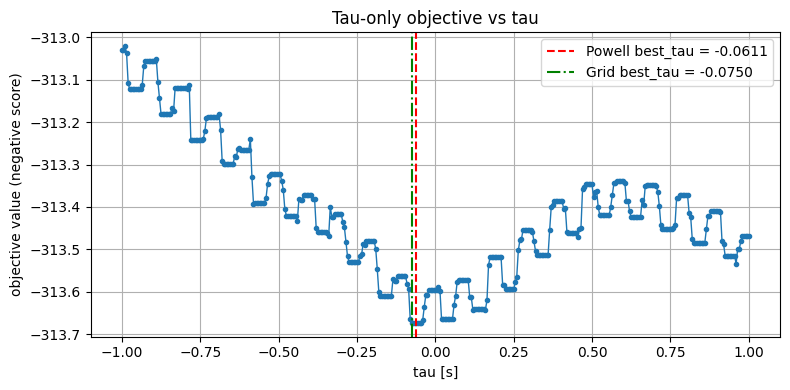

In [9]:
# ---- Sweep tau around the optimum ----
# Center window around best_tau, or just use a fixed range like [-1.0, 1.0]
tau_min = -1.00
tau_max =  1.00
num_samples = 401   # step = (1 - (-1))/400 = 0.005

taus = np.linspace(tau_min, tau_max, num_samples)
vals = []

print("\nStep Size = 0.005")
print("\nSweeping tau for objective curve...")
start = time.time()
for t in taus:
    val = tau_only_objective(
        np.array([t], dtype=float),
        pipeline,
        lidar_scans,
        cam_times,
        frame_ids,
        K,
        T_CL_init,
        scan_indices=None,
        max_points_per_scan=5000,
    )
    vals.append(val)
    print(f"tau = {t:+.4f}  objective = {val:.3f}")
end = time.time()

vals = np.array(vals)
print(f"\nGrid search time: {end - start:.3f} s")

# ---- Find best tau from grid search ----
idx_best = np.argmin(vals)
best_tau_grid = taus[idx_best]
best_obj_grid = vals[idx_best]

print(f"\nGrid-search best tau = {best_tau_grid:.6f} s")
print(f"Grid-search best objective = {best_obj_grid:.6f}")

# ---- Plot ----
plt.figure(figsize=(8, 4))
plt.plot(taus, vals, marker='o', markersize=3, linewidth=1)
plt.axvline(best_tau, color='r', linestyle='--', label=f'Powell best_tau = {best_tau:.4f}')
plt.axvline(best_tau_grid, color='g', linestyle='-.', label=f'Grid best_tau = {best_tau_grid:.4f}')
plt.xlabel('tau [s]')
plt.ylabel('objective value (negative score)')
plt.title('Tau-only objective vs tau')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


--- tau = -1.0000 ---
target cam time = 1763574253.165854
selected frame_id = 22

--- tau = -0.0611 ---
target cam time = 1763574254.104798
selected frame_id = 41

--- tau = +0.2500 ---
target cam time = 1763574254.415854
selected frame_id = 47


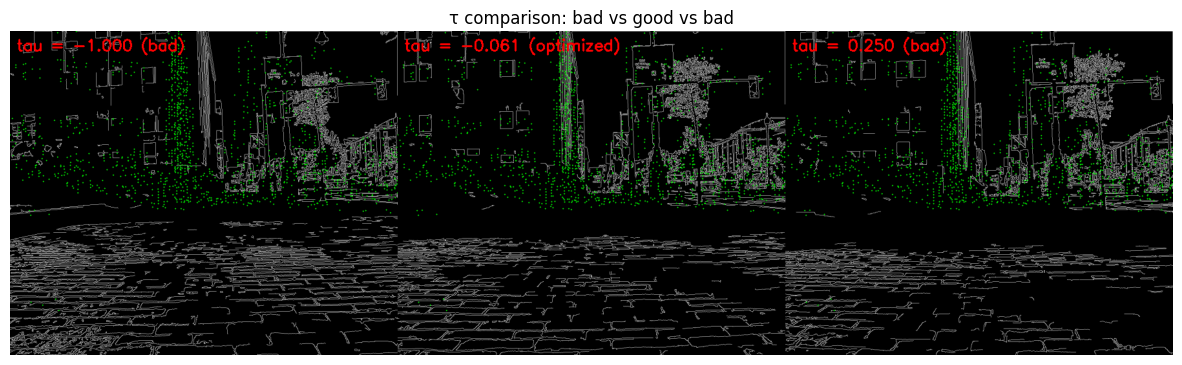

In [10]:
# ----------------------------------------
# Helper: build overlay image and RETURN it
# ----------------------------------------
def make_overlay_image(pipeline, frame_id, projected_pixels,
                       show_edges=True,
                       max_width=600, max_height=600,
                       label_text=None):
    """
    Returns a BGR overlay image with projected LiDAR points.
    Cleaner + returns image instead of showing directly.
    """
    base = pipeline.edge_maps[frame_id] if (show_edges and frame_id in pipeline.edge_maps) else pipeline.images[frame_id]
    h, w = base.shape

    overlay = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)

    if projected_pixels is not None and len(projected_pixels) > 0:
        pts = projected_pixels.astype(np.int32)
        mask = (
            (pts[:, 0] >= 0) & (pts[:, 0] < w) &
            (pts[:, 1] >= 0) & (pts[:, 1] < h)
        )
        pts = pts[mask]

        for (u, v) in pts:
            cv2.circle(overlay, (int(u), int(v)), 2, (0, 255, 0), -1)

    # resize to common size
    oh, ow = overlay.shape[:2]
    scale = min(max_width / ow, max_height / oh, 1.0)
    if scale < 1.0:
        overlay = cv2.resize(overlay, (int(ow * scale), int(oh * scale)), interpolation=cv2.INTER_AREA)

    # label
    if label_text is not None:
        cv2.putText(overlay, label_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    return overlay


# ----------------------------------------
# Choose one LiDAR scan
# ----------------------------------------
scan_idx = 20  
scan = lidar_scans[scan_idx]
t_L   = float(scan["timestamp"])
pts_L = scan["points"]

# subsample for speed
max_pts_vis = 20000
if pts_L.shape[0] > max_pts_vis:
    idx = np.random.choice(pts_L.shape[0], max_pts_vis, replace=False)
    pts_L_vis = pts_L[idx]
else:
    pts_L_vis = pts_L

# project LiDAR to camera coordinates ONCE
uv = lidar_points_to_pixels(pts_L_vis, T_CL_init, K)

# ----------------------------------------
# Evaluate 3 τ values: bad, good, bad
# ----------------------------------------
tau_good = best_tau
tau_tests = [
    (-1.0,          "tau = -1.000 (bad)"),
    (tau_good,      f"tau = {tau_good:.3f} (optimized)"),
    (0.25,          "tau = 0.250 (bad)"),
]

overlays = []

for tau_val, label in tau_tests:
    t_C = t_L + tau_val
    frame_id = closest_frame_id(cam_times, frame_ids, t_C)

    print(f"\n--- tau = {tau_val:+.4f} ---")
    print(f"target cam time = {t_C:.6f}")
    print(f"selected frame_id = {frame_id}")

    img = make_overlay_image(
        pipeline, frame_id, uv,
        show_edges=True,
        label_text=label,
        max_width=600,
        max_height=600
    )
    overlays.append(img)

# ----------------------------------------
# Stack and show INLINE
# ----------------------------------------
# equalize heights
min_h = min(img.shape[0] for img in overlays)
resized = [
    cv2.resize(img, (int(img.shape[1] * min_h / img.shape[0]), min_h))
    for img in overlays
]

combined = np.hstack(resized)

# OpenCV uses BGR, matplotlib expects RGB
combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.imshow(combined_rgb)
plt.axis('off')
plt.title("τ comparison: bad vs good vs bad")
plt.show()
